# Continuous data generation

In [1]:
import random
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font', **{'family' : "sans-serif"})
params= {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amsfonts}', r'\usepackage{bm}']}
plt.rcParams.update(params)
from matplotlib2tikz import save as tikz_save

In [2]:
# n: sample size; d1: continuous features' dimension;
# x_quant: U([0,1]); xd_quant: "true" generating data of Y
n = 10000
d1 = 2
cuts = ([0,0.333,0.666,1])
replicates = 20
# The true logistic regression parameter is fixed
if d1>0: 
    theta_quant = np.array([[0]*d1]*(len(cuts)-1))
    theta_quant[1,:] = 2
    theta_quant[2,:] = -2

In [3]:
def generate_data(seed=0):
    random.seed(seed)
    x_quant = np.array(np.random.uniform(size=(n,d1)))
    xd_quant = np.ndarray.copy(x_quant)
    # x_quant is cut in thirds into xd_quant
    for i in range(d1):
        xd_quant[:,i] = pd.cut(x_quant[:,i],bins=cuts,labels=[0,1,2])
# The log odd probabilities of Y given each x_i can be exactly calculated
    log_odd = np.array([0]*n)
    for i in range(n):
        for j in range(d1):
            log_odd[i] += theta_quant[int(xd_quant[i,j]),j]
# Y is then drawn from this pdf
    p = 1/(1+np.exp(-log_odd))
    y = np.random.binomial(1,p)

    return([x_quant,y])

# Neural network architecture

In [4]:
# We rely on Keras for all calculations and the TensorFlow backend.
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras import *
from keras.layers import *
from keras.callbacks import LambdaCallback, Callback, ReduceLROnPlateau , TensorBoard
import sklearn.linear_model    

In [6]:
m_quant = [10,10]

def initialize_neural_net():
    liste_inputs_quant = [None]*d1
    liste_layers_quant = [None]*d1
    liste_layers_quant_inputs = [None]*d1


    for i in range(d1):
        liste_inputs_quant[i] = Input((1,))
        liste_layers_quant[i] = Dense(m_quant[i],activation ='softmax')
        liste_layers_quant_inputs[i] = liste_layers_quant[i](liste_inputs_quant[i])

    return([liste_inputs_quant,liste_layers_quant,liste_layers_quant_inputs])

In [7]:
def evaluate_disc(prob=[]):
        
    results = [None]*d1
    
    X_transformed = np.ones((n,1))

    for j in range(d1):
        results[j] = np.argmax(prob[j][0],axis=1)
        X_transformed = np.concatenate((X_transformed,sk.preprocessing.OneHotEncoder().fit_transform(X=results[j].reshape(-1, 1)).toarray()),axis=1)
        
    proposed_logistic_regression = sk.linear_model.LogisticRegression(fit_intercept=False)
    
    proposed_logistic_regression.fit(X=X_transformed,y=y.reshape((n,)))
    
    BIC_training = 2*sk.metrics.log_loss(y, proposed_logistic_regression.predict_proba(X=X_transformed)[:,1],normalize=False) + proposed_logistic_regression.coef_.shape[1]*np.log(n)
    
    return(BIC_training)

In [8]:
from matplotlib import colors as mcolors

In [9]:
colors = list(mcolors.CSS4_COLORS.keys())

In [11]:
class LossHistory(Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.best_criterion = float("inf")
        self.best_outputs = []
        self.epochs = 0

    def on_epoch_end(self, batch, logs={}):
        self.epochs += 1
        outputs = []
        
        for j in range(d1):
            outputs.append(K.function([liste_layers_quant[j].input],[liste_layers_quant[j].output])([x_quant[:,j,np.newaxis]]))
            plt.xlim((0,1))
            plt.ylim((0,1))
            for k in range(outputs[j][0].shape[1]):
                plt.plot(np.sort(x_quant[list(range(0,x_quant.shape[0],3)),j]),outputs[j][0][np.argsort(x_quant[list(range(0,x_quant.shape[0],3)),j]),k], label = r'$\mathfrak{s}_{\bm{\alpha}_{'+str(j)+','+str(k)+'}}$', color = colors[k+2])
            plt.title('Continuous feature '+str(j)+' at iteration ' + str(self.epochs))
            plt.ylabel(r'$\mathfrak{s}_{\bm{\alpha}_{'+str(j)+',h}}$')
            plt.xlabel(r'$x_1$')
            plt.axvline(x=0.33333, label = r'$c_{'+str(j)+',1}$', color = 'g', linestyle = '--')
            plt.axvline(x=0.66666, label = r'$c_{'+str(j)+',2}$', color = 'b', linestyle = '--')
            plt.text(0.10, 0.95, r'$\mathfrak{q}_{'+str(j)+',1}$', fontsize=14, verticalalignment='top')
            plt.text(0.50, 0.95, r'$\mathfrak{q}_{'+str(j)+',2}$', fontsize=14, verticalalignment='top')
            plt.text(0.90, 0.95, r'$\mathfrak{q}_{'+str(j)+',3}$', fontsize=14, verticalalignment='top')
            df = pd.DataFrame(np.column_stack((x_quant[:,j],np.argmax(outputs[j][0],axis=1))),columns=['continuous','discrete'])
            grouped_data = df.groupby('discrete', as_index=False)['continuous']
            results = [grouped_data.max(),grouped_data.min()]
            results[0]['continuous'].values[::-1].sort()
            results[1]['continuous'].values[::-1].sort()
            moyennes = np.column_stack((results[0]['continuous'].values[1:,np.newaxis],results[1]['continuous'].values[:-1,np.newaxis])).mean(axis=1)
            for k in reversed(range(moyennes.shape[0])):
                plt.axvline(x=moyennes[k], label = r'$\hat{c}_{'+str(j)+','+str(moyennes.shape[0]-k+1)+'}$', color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'][k], linestyle = '-')
            plt.legend(loc='center right')
            if (self.epochs == 5):
                tikz_save('false_feature_'+str(j)+'_iteration_'+str(self.epochs)+'.tex', figureheight = '\\figureheight',figurewidth='\\figurewidth')
                plt.close()
            if (self.epochs == 600):
                tikz_save('false_feature_'+str(j)+'_iteration_'+str(self.epochs)+'.tex', figureheight = '\\figureheight',figurewidth='\\figurewidth')
                plt.close()
            plt.show()

        self.losses.append(evaluate_disc(prob = outputs))
        
        if self.losses[-1] < self.best_criterion:
            self.best_outputs = outputs
            self.best_criterion = self.losses[-1]

# Results

## Discretization of each continuous feature

Epoch 1/400
10000/10000 [==============================] - 2s 180us/step - loss: 0.5905 - acc: 0.6934


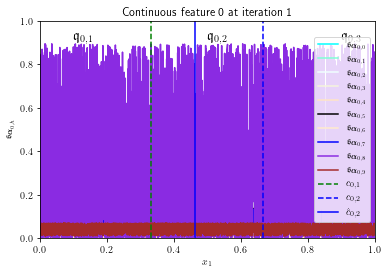

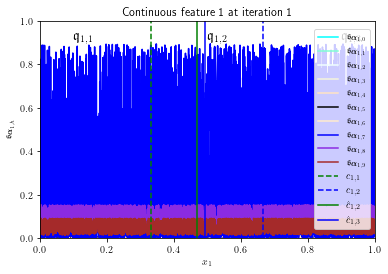

Epoch 2/400
10000/10000 [==============================] - 1s 78us/step - loss: 0.5141 - acc: 0.7495


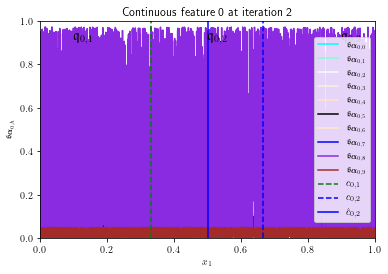

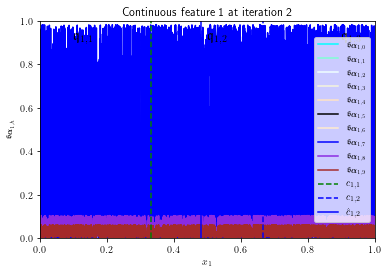

Epoch 3/400
10000/10000 [==============================] - 1s 75us/step - loss: 0.4978 - acc: 0.7561


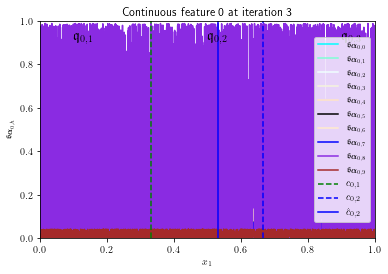

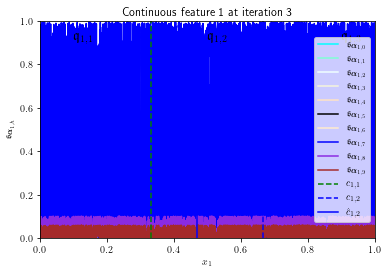

Epoch 4/400
10000/10000 [==============================] - 1s 68us/step - loss: 0.4933 - acc: 0.7614


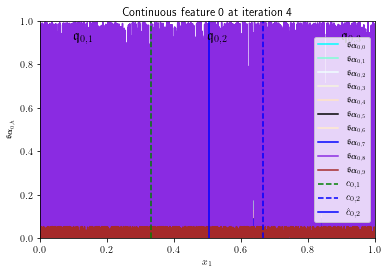

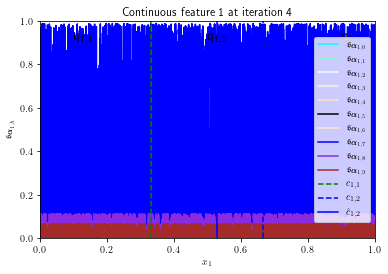

Epoch 5/400
10000/10000 [==============================] - 1s 77us/step - loss: 0.4900 - acc: 0.7595
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Epoch 6/400
10000/10000 [==============================] - 1s 87us/step - loss: 0.4887 - acc: 0.7586


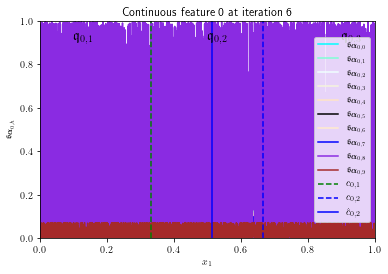

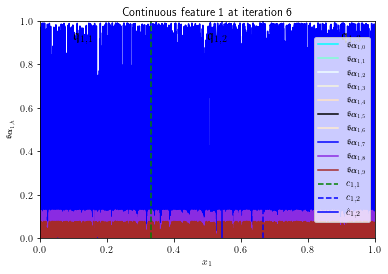

Epoch 7/400
10000/10000 [==============================] - 1s 99us/step - loss: 0.4847 - acc: 0.7667


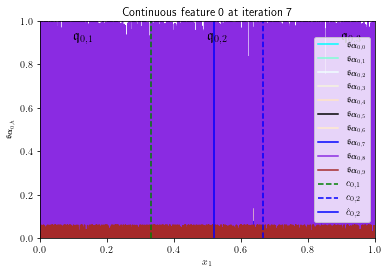

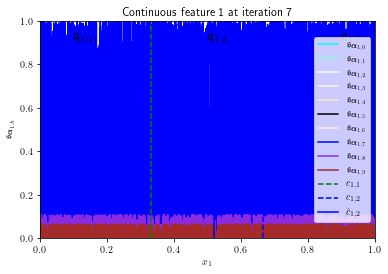

Epoch 8/400
10000/10000 [==============================] - 1s 98us/step - loss: 0.4830 - acc: 0.7655


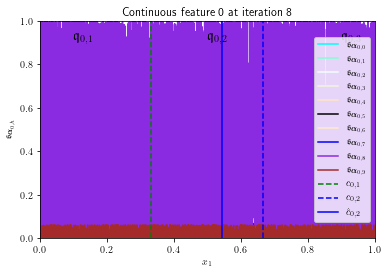

In [ ]:
from itertools import chain
results = []

for rep in range(replicates):
    
    # Simulate data
    x_quant, y = generate_data(seed=rep+100)
    
    # Set up a new model
    
    liste_inputs_quant, liste_layers_quant,liste_layers_quant_inputs = initialize_neural_net()
    output = Dense(1,activation='sigmoid')(concatenate(liste_layers_quant_inputs))
    model = Model(inputs = liste_inputs_quant,outputs = [output])
    #opt = optimizers.Adadelta(lr=6.0, rho=0.98, epsilon=None, decay=0.0)
    #opt = optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
    opt = optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    
    # Train the model
    history = LossHistory()
    callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0),history]
    model.fit(list(x_quant.T),y,epochs=400, batch_size=30, verbose=1, callbacks = callbacks)
    
    # Get the best outputs
    results.append([])
    for j in range(d1):
        df = pd.DataFrame(np.column_stack((x_quant[:,j],np.argmax(history.best_outputs[j][0],axis=1))),columns=['continuous','discrete'])
        grouped_data = df.groupby('discrete', as_index=False)['continuous']
        results[rep].append([grouped_data.max(),grouped_data.min()])

In [12]:
estim_m_1 = []
for rep in range(10):
    for j in range(d1):
        results[rep][j][0]['continuous'].values[::-1].sort()
        results[rep][j][1]['continuous'].values[::-1].sort()
        moyennes = np.column_stack((results[rep][j][0]['continuous'].values[1:,np.newaxis],results[rep][j][1]['continuous'].values[:-1,np.newaxis])).mean(axis=1)
        estim_m_1.append(len(moyennes)+1)

In [13]:
estim_m_1

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [14]:
estim_m_1_previous_10000 = [
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
]

In [1]:
estim_m_1_previous_1000 = [
    3,
    3,
    2,
    3,
    4,
    3,
    3,
    3,
    3,
    3,
    2,
    2,
    2,
    3,
    3,
    3,
    4,
    3,
    2,
    2,
    5,
    2,
    3,
    3,
    3,
    3,
    2,
    3,
    2,
    3,
    3,
    3,
    2,
    2,
    4,
    3,
    3,
    3,
    3,
    2,
    4,
    3,
    3,
    3,
    2,
    3,
    3,
    3,
    2,
    3,
    3,
    2,
    2,
    2,
    3,
    3,
    3,
    2,
    2,
    3,
    3,
    3,
    3,
    3,
    4,
    2,
    4,
    3,
    3,
    2,
    3,
    4,
    3,
    3,
    3,
    2,
    3,
    3,
    3,
    5,
    3,
    2,
    2,
    2,
    3,
    3,
    3,
    3,
    2,
    2,
    2,
    2,
    3,
    3,
    3,
    2,
    3,
    2,
    4,
    3,
]

In [4]:
import numpy as np
sum(np.where(estim_m_1_previous_1000 == 2))

array([], dtype=int64)

In [9]:
[sum([x==4 for x in estim_m_1_previous_1000]),sum([x==2 for x in estim_m_1_previous_1000]),sum([x==3 for x in estim_m_1_previous_1000])]

[8, 31, 59]

In [10]:
[sum([x==4 for x in estim_m_1_previous_10000]),sum([x==2 for x in estim_m_1_previous_10000]),sum([x==3 for x in estim_m_1_previous_10000])]

NameError: name 'estim_m_1_previous_10000' is not defined

In [15]:
len(estim_m_1_previous_10000)

110

In [16]:
import scipy.stats as st

st.t.interval(0.95, len(estim_m_1_previous_10000[:100]), loc=np.mean(estim_m_1_previous_10000[:100]), scale=st.sem(estim_m_1_previous_10000[:100]))

/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


(nan, nan)

In [ ]:
# Helper functions for TF Graph visualization
from IPython.display import clear_output, Image, display, HTML
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
graph_def = tf.get_default_graph().as_graph_def()
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

# Interaction screening in logistic regression